In [1]:
# stdlib
import os

# Testing works over 4 possibilities
# 1. (python/in-memory workers and using tox commands)
# 2. (python/in-memory workers and manually running notebooks)
# 3. (using k8s and using tox commands)
# 4. (using k8s and manually running notebooks)
# Uncomment the lines below if in the 4th possibility

# os.environ["ORCHESTRA_DEPLOYMENT_TYPE"] = "remote"
# os.environ["DEV_MODE"] = "True"
# os.environ["TEST_EXTERNAL_REGISTRY"] = "k3d-registry.localhost:5800"
# os.environ["CLUSTER_HTTP_PORT_HIGH"] = "9081"
# os.environ["CLUSTER_HTTP_PORT_LOW"] = "9083"

In [7]:
# stdlib
environment = os.environ.get("ORCHESTRA_DEPLOYMENT_TYPE", "python")
high_port = os.environ.get("CLUSTER_HTTP_PORT_HIGH", "9081")
low_port = os.environ.get("CLUSTER_HTTP_PORT_LOW", "9083")
print(environment, high_port, low_port)

python 9081 9083


In [8]:
# syft absolute
import syft as sy
from syft import test_settings
from syft.util.test_helpers.worker_helpers import (
    build_and_launch_worker_pool_from_docker_str,
)
from syft.util.test_helpers.worker_helpers import (
    launch_worker_pool_from_docker_tag_and_registry,
)

# Launch server & login

In [9]:
server_low = sy.orchestra.launch(
    name="bigquery-low",
    server_side_type="low",
    dev_mode=True,
    reset=True,
    n_consumers=1,
    create_producer=True,
    port=low_port,
)

server_high = sy.orchestra.launch(
    name="bigquery-high",
    server_side_type="high",
    dev_mode=True,
    reset=True,
    n_consumers=1,
    create_producer=True,
    port=high_port,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Autoreload enabled
Starting bigquery-low server on 0.0.0.0:9083


INFO:     Will watch for changes in these directories: ['/Users/koen/workspace/PySyft/packages/syft/src/syft']
ERROR:    [Errno 48] Address already in use


Found `reset=True` in the launch configuration. Resetting the server...


SyftInfo: You have launched a development server at http://0.0.0.0:9083. It is intended only for local use.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Autoreload enabled
Starting bigquery-high server on 0.0.0.0:9081


INFO:     Will watch for changes in these directories: ['/Users/koen/workspace/PySyft/packages/syft/src/syft']
ERROR:    [Errno 48] Address already in use


Found `reset=True` in the launch configuration. Resetting the server...
 Done.


SyftInfo: You have launched a development server at http://0.0.0.0:9081. It is intended only for local use.

In [10]:
# start email server here

In [12]:
low_client = server_low.login(email="info@openmined.org", password="changethis")

ConnectionError: Failed to fetch http://localhost:9083/api/v2/metadata. Response returned with code 502

In [13]:
high_client = server_high.login(email="info@openmined.org", password="changethis")

Logged into <syft-dev-server: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

In [23]:
high_client = sy.login(url="http://localhost", port=8080, email="info@openmined.org", password="changethis")

Logged into <syft-dev-server: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

In [ ]:
bae980ecdebda81ca370b90115bb2e00e704d512bf310349ea16ba098f10c46a

In [26]:
str(high_client.credentials)

'bae980ecdebda81ca370b90115bb2e00e704d512bf310349ea16ba098f10c46a'

<DatasiteClient: syft-dev-server>
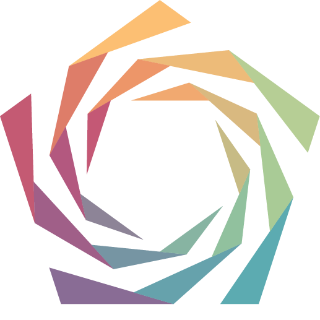

In [21]:
high_client

In [19]:
high_client.credentials

<Corresponding Public Key: dbc301111ecc961c8326e79f3e204a2d31505d1f796fa4a130842752dfed744c>

In [ ]:
assert len(high_client.worker_pools.get_all()) == 1
assert len(low_client.worker_pools.get_all()) == 1

# Setup High First

- If using an external registery, we want to get this from the test_settings.
- We build the docker image over the base docker image in Syft
- We give a tag called worker-bigquery to our custom pool image

In [ ]:
external_registry = test_settings.get("external_registry", default="docker.io")

base_worker_image = high_client.images.get_all()[0]

worker_dockerfile = f"""
FROM {str(base_worker_image.image_identifier)}

RUN uv pip install db-dtypes google-cloud-bigquery 

""".strip()

docker_tag = str(base_worker_image.image_identifier).replace(
    "backend", "worker-bigquery"
)

In [ ]:
worker_pool_name = "bigquery-pool"
custom_pool_pod_annotations = {"bigquery-custom-pool": "Pod annotation for bigquery"}
custom_pool_pod_labels = {"bigquery-custom-pool": "Pod_label_for_bigquery"}

In [ ]:
build_and_launch_worker_pool_from_docker_str(
    environment=environment,
    client=high_client,
    worker_pool_name=worker_pool_name,
    custom_pool_pod_annotations=custom_pool_pod_annotations,
    custom_pool_pod_labels=custom_pool_pod_labels,
    worker_dockerfile=worker_dockerfile,
    external_registry=external_registry,
    docker_tag=docker_tag,
    scale_to=2,
)

In [ ]:
assert len(high_client.worker_pools.get_all()) == 2

In [ ]:
high_client.settings.allow_guest_signup(enable=False)

# Setup Low

In [ ]:
launch_result = launch_worker_pool_from_docker_tag_and_registry(
    environment=environment,
    client=low_client,
    worker_pool_name=worker_pool_name,
    custom_pool_pod_annotations=custom_pool_pod_annotations,
    custom_pool_pod_labels=custom_pool_pod_labels,
    docker_tag=docker_tag,
    external_registry=external_registry,
    scale_to=1,
)

In [ ]:
assert len(low_client.worker_pools.get_all()) == 2

# Register a DS only on the low side

In [ ]:
low_client.register(
    email="data_scientist@openmined.org",
    password="verysecurepassword",
    password_verify="verysecurepassword",
    name="John Doe",
)

In [ ]:
low_client.settings.allow_guest_signup(enable=False)

In [ ]:
assert (
    len(low_client.api.services.user.get_all()) == 2
), "Only DS and Admin should be at low side"
assert (
    len(high_client.api.services.user.get_all()) == 1
), "Only Admin should be at high side"

# Close

In [ ]:
if environment != "remote":
    server_high.land()
    server_low.land()

In [ ]:
# TODO close email client